

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://gym.openai.com/envs/CartPole-v1/)).


##Libraries

In [1]:
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hyperparameters

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 100000
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 300
SAVE_STEPS = 512
FINISH_STEPS = 14848
MAX_STEPS = 2000

## Class ReplayMemory

Memory of transitions for experience replay.

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [4]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(24, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states)
        q_next_states = self.model.predict(next_states)

        for i in range(BATCH_SIZE):
            if (terminal_states[i]):
                q_targets[i][actions[i]] = rewards[i]
            else:
                q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")            

## Environment Cartpole

Cartpole simulator from [Open Ai Gym](https://gym.openai.com/envs/CartPole-v1/):

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [5]:
def create_environment():
    # Create simulated environment
    environment = gym.make("CartPole-v0")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

In [6]:
def test(a):
    env_name = 'CartPole-v0'       
    env = gym.make(env_name)
    state = env.reset()
    score = 0
    scores = []

    done = False
    for ii in range(10):
        while done == False:
            action = a.select(state)
            state, reward, done, _ = env.step(action)
            score += reward
        done = False
        scores.append(score)
        score = 0
        state = env.reset()

    env.close()
    scores_step = sum(scores)/10
    return scores_step

## Main program




Episode   1: score 21.0 Average score 23.0 
Episode   2: score 14.0 Average score 19.5 
Episode   3: score 17.0 Average score 19.333333333333332 
Episode   4: score 50.0 Average score 27.5 
Episode   5: score 13.0 Average score 25.0 
Episode   6: score 8.0 Average score 22.5 
Episode   7: score 8.0 Average score 20.714285714285715 
Episode   8: score 19.0 Average score 20.75 
Episode   9: score 10.0 Average score 19.77777777777778 
Episode  10: score 10.0 Average score 19.0 
Episode  11: score 11.0 Average score 18.454545454545453 
Episode  12: score 10.0 Average score 17.916666666666668 
Episode  13: score 13.0 Average score 17.692307692307693 
Episode  14: score 17.0 Average score 17.785714285714285 
Episode  15: score 10.0 Average score 17.4 
Episode  16: score 9.0 Average score 17.0 
Episode  17: score 10.0 Average score 16.705882352941178 
Episode  18: score 9.0 Average score 16.38888888888889 
Episode  19: score 13.0 Average score 16.31578947368421 
Episode  20: score 8.0 Average

Episode 164: score 43.0 Average score 32.19 
Episode 165: score 192.0 Average score 34.01 
Episode 166: score 77.0 Average score 34.68 
Episode 167: score 89.0 Average score 35.29 
Episode 168: score 63.0 Average score 35.65 
Episode 169: score 87.0 Average score 35.2 
Episode 170: score 61.0 Average score 34.62 
Episode 171: score 73.0 Average score 35.13 
Episode 172: score 75.0 Average score 35.37 
Episode 173: score 85.0 Average score 36.03 
Episode 174: score 140.0 Average score 37.19 
Episode 175: score 199.0 Average score 38.94 
Episode 176: score 175.0 Average score 40.55 
Episode 177: score 195.0 Average score 42.36 
Episode 178: score 199.0 Average score 44.13 
Episode 179: score 146.0 Average score 45.39 
Episode 180: score 135.0 Average score 46.58 
Episode 181: score 139.0 Average score 47.85 
Episode 182: score 199.0 Average score 49.68 
Episode 183: score 166.0 Average score 51.22 
Episode 184: score 177.0 Average score 52.87 
Episode 185: score 161.0 Average score 54.34

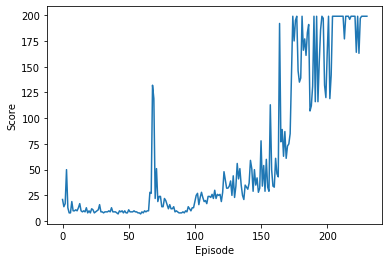

In [7]:
import time
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
scores = []
rew_step = []
start_time = time.perf_counter()
total_steps = 0
start = time.time()

while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    
    if total_steps > FINISH_STEPS:
        break
    
    episode += 1
    step = 1
    end_episode = False
    state = environment.reset()
    reward_accumulated = 0
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)

        # Execute the action on the environment
        state_next, reward, terminal_state, info = environment.step(action)
        
        #if episode == NUMBER_OF_EPISODES:
        #    environment.render()

        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)
        
        #print(state[0],reward)
        
        # Learn using a batch of experience stored in memory
        agent.learn()
  
        #if total_steps % SAVE_STEPS == 0:
        #    rew_step.append(test(agent))
        #    print('Guardo')
        
        if total_steps > FINISH_STEPS:
            break

        # Detect end of episode
        if terminal_state:
            step += 1
            scores.append(step)
            agent.add_score(reward_accumulated)
            if episode < 100:
                avg_score = sum(scores)/len(scores)
            else:
                avg_score = sum(scores[-100:])/100
            if avg_score >= 195:
                goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(reward_accumulated), end = '')
            print("Average score {0:>3} ".format(avg_score))
            end_episode = True
            
        else:
            state = state_next
            step += 1
            total_steps += 1
            reward_accumulated += reward

environment.close()   
if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

'''   
counter_file = 1
NAME2 = 'DQN_cartpole_steps_' + str(counter_file) + '.txt'            
    
output_file2 = open(NAME2, 'w')
for rew in rew_step:
    output_file2.write(str(rew) + '\n')

output_file2.close()
''' 
environment.close()
if goal_reached:
    print("Reached goal sucessfully.")
else:
    print("Failure to reach the goal.")    
  

print("Time:", ((time.time() - start)/60), "minutes")

agent.display_scores_graphically()

DQN sin target network y carpotle v0